# Entropy

In [0]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Sequential, Model
from keras.utils import to_categorical


def load_flatten_mnist_dataset():
  # Load the MNIST dataset from Keras
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # Rescale images
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  # Reshape images
  x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
  # Return the preprocessed MNIST images
  return x_train, y_train, x_test, y_test

def create_classifier(input_dimension=784, output_dimension=10):
  # Create the classifier model
  classifier = Sequential()
  classifier.add(Dense(64, input_dim=input_dimension, activation='relu'))
  classifier.add(Dense(16, activation='relu'))
  classifier.add(Dense(output_dimension, activation='softmax'))
  # Compile the classifier model
  classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return classifier


# Load the MNIST dataset (flattened to 784-long)
x_train, y_train, x_test, y_test = load_flatten_mnist_dataset()

# Create the classifier model that will discriminate latent dimensions
classifier = create_classifier(input_dimension=784, output_dimension=10)

# Fit the classifier to make it predict the MNIST figures from latent vectors
classifier.fit(x_train, to_categorical(y_train), epochs=10, batch_size=32)

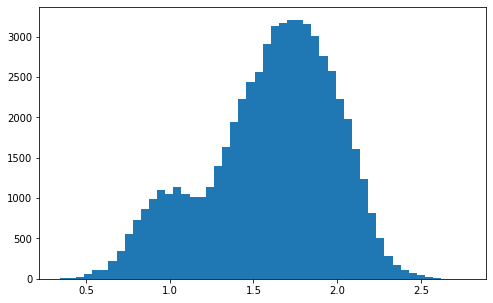

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


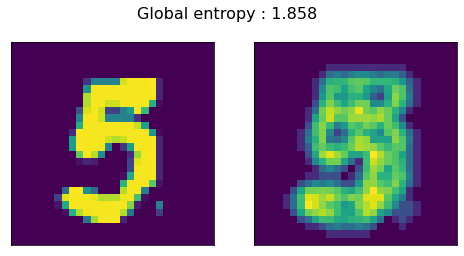

In [0]:
import matplotlib.pyplot as plt
from skimage.measure.entropy import shannon_entropy
from skimage.filters.rank import entropy
from skimage.morphology import disk


def compute_image_global_entropy(input_image):
  # Compute the global Shannon entropy score of the image
  return shannon_entropy(input_image)

def compute_image_local_entropy(input_image, neighbourhood):
  # Compute the local entropy score of the image with respect to a neighbourhood
  return entropy(input_image, disk(neighbourhood))

def plot_single_image_entropy(image):
  # Compute local and global entropies for the input image
  local_entropy_image = compute_image_local_entropy(image, neighbourhood=2)
  global_entropy_image = round(compute_image_global_entropy(image), 3)
  # Display both entropies on a two-parts plot
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  axs[0].imshow(image) ; axs[0].set_xticks([]) ; axs[0].set_yticks([])
  axs[1].imshow(local_entropy_image) ; axs[1].set_xticks([]) ; axs[1].set_yticks([])
  fig.suptitle('Global entropy : {}'.format(global_entropy_image), fontsize=16)
  plt.show()

def compute_global_entropy_all_images(input_images):
  # Compute the global entropy score for all images
  return [compute_image_global_entropy(input_images[i]) for i in range(input_images.shape[0])]

def plot_global_entropy_histogram_all_images(input_images):
  # Compute the global entropy score for all images
  global_entropies = compute_global_entropy_all_images(input_images)
  # Display the histogram of global entropy for all images
  plt.figure(figsize=(8, 5))
  plt.hist(global_entropies, bins=50)
  plt.show()


# Plot the entropy histogram of all training images
plot_global_entropy_histogram_all_images(x_train.reshape(-1, 28, 28))

# Plot the local and global entropies for a single and random image
random_index = np.random.choice(x_train.shape[0])
random_image = x_train[random_index].reshape(28, 28)
plot_single_image_entropy(random_image)

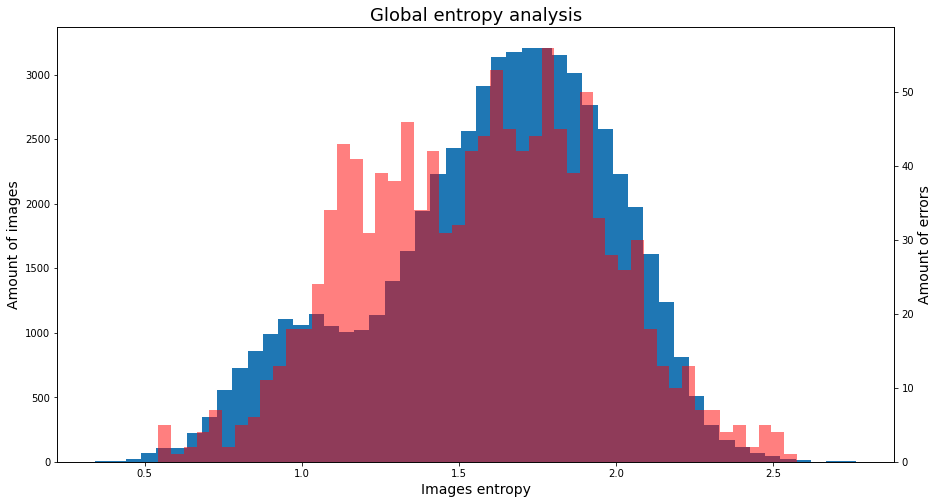

In [0]:
def plot_global_entropy_analysis(global_entropies, entropies_errors):
  # Plot the distribution of the images global entropies
  fig, ax1 = plt.subplots(figsize=(15, 8))
  plt.title('Global entropy analysis', fontsize=18)
  ax1.hist(global_entropies, bins=50)
  ax1.set_xlabel('Images entropy', fontsize=14)
  ax1.set_ylabel('Amount of images', fontsize=14)
  # Plot the errors related to the images global entropies
  ax2 = ax1.twinx()
  ax2.hist(entropies_errors, bins=50, color='r', alpha=0.5)
  ax2.set_ylabel('Amount of errors', fontsize=14)
  plt.show()


# Make predictions with the previously trained classifier
predictions = np.argmax(classifier.predict(x_train), axis=1)
# Compute the entropies of all training images
entropies = np.array(compute_global_entropy_all_images(x_train.reshape(-1, 28, 28)))

# Compute the indices where the model made false predictions/errors
errors_indices = np.where(predictions != y_train)[0]
# Retrieve the related global entropies of the images where the model made mistakes
entropies_errors = entropies[errors_indices]

# Plot the global entropy analysis (distribution/errors)
plot_global_entropy_analysis(entropies, entropies_errors)